In [1]:
from hydra import initialize, compose
from hydra.utils import instantiate

import numpy as np

import torch

import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.utilities import move_data_to_device

from bliss.global_env import GlobalEnv

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

Configure encoder to make predictions using weights from a previous training run:

In [2]:
ckpt = "/data/scratch/twhit/checkpoints/trained_encoder_dc2.ckpt"

with initialize(config_path="../../", version_base=None):
    cfg = compose("lensing_config_dc2", {
        "train.pretrained_weights=" + ckpt,
        })

seed = pl.seed_everything(cfg.train.seed)
GlobalEnv.seed_in_this_program = seed

Seed set to 123123


Load in the test images:

In [3]:
data_source = instantiate(cfg.train.data_source)
data_source.setup("test")
test_dl = data_source.test_dataloader()

In [4]:
test_data = []
for batch in test_dl:
    test_data.append(move_data_to_device(batch, device))

Load in encoder weights:

In [5]:
encoder = instantiate(cfg.encoder).to(device)
encoder_state_dict = torch.load(cfg.train.pretrained_weights, map_location=device)["state_dict"]
encoder.load_state_dict(encoder_state_dict)
encoder = encoder.eval()

Store true and posterior mode shear and convergence for the test images:

In [6]:
shear1_true = torch.zeros(len(test_data), 8, 8, device=device)
shear1_pred = torch.zeros(len(test_data), 8, 8, device=device)
shear2_true = torch.zeros(len(test_data), 8, 8, device=device)
shear2_pred = torch.zeros(len(test_data), 8, 8, device=device)
convergence_true = torch.zeros(len(test_data), 8, 8, device=device)
convergence_pred = torch.zeros(len(test_data), 8, 8, device=device)
ra = torch.zeros(len(test_data), 8, 8, device=device)
dec = torch.zeros(len(test_data), 8, 8, device=device)

for i in range(len(test_data)):
    shear1_true[i] = test_data[i]['tile_catalog']['shear_1'].squeeze()
    shear2_true[i] = test_data[i]['tile_catalog']['shear_2'].squeeze()
    convergence_true[i] = test_data[i]['tile_catalog']['convergence'].squeeze()
    ra[i] = test_data[i]['tile_catalog']['ra'].squeeze()
    dec[i] = test_data[i]['tile_catalog']['dec'].squeeze()
    
    with torch.no_grad():
        mode_cat = encoder.sample(test_data[i], use_mode=True)
    
    shear1_pred[i] = mode_cat['shear_1'].squeeze()
    shear2_pred[i] = mode_cat['shear_2'].squeeze()
    convergence_pred[i] = mode_cat['convergence'].squeeze()

Compute test MSEs:

In [7]:
print(f'shear 1 test MSE = {((shear1_true - shear1_pred) ** 2).mean()}')
print(f'shear 2 test MSE = {((shear2_true - shear2_pred) ** 2).mean()}')
print(f'convergence test MSE = {((convergence_true - convergence_pred) ** 2).mean()}')

shear 1 test MSE = 5.8391633501742035e-05
shear 2 test MSE = 5.8046611229656264e-05
convergence test MSE = 6.798046524636447e-05


Compute test correlation coefficients:

In [8]:
print(f'shear 1 corr coef = {np.corrcoef(shear1_true.flatten().cpu(), shear1_pred.flatten().cpu())[1,0]}')
print(f'shear 2 corr coef = {np.corrcoef(shear2_true.flatten().cpu(), shear2_pred.flatten().cpu())[1,0]}')
print(f'convergence corr coef = {np.corrcoef(convergence_true.flatten().cpu(), convergence_pred.flatten().cpu())[1,0]}')

shear 1 corr coef = 0.4263970939390294
shear 2 corr coef = 0.43433952595026937
convergence corr coef = 0.7404062604826877


Compute test loss:

In [9]:
with torch.no_grad():
    print(f'test loss = {np.mean([encoder._compute_loss(test_data[i], None).cpu() for i in range(len(test_data))])}')

/home/twhit/bliss/.venv/lib/python3.10/site-packages/pytorch_lightning/core/module.py:447: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


test loss = -10.35970401763916


Estimate linear regression coefficients on test images:

In [10]:
print(f'shear 1 1+m = {(shear1_true.flatten() * shear1_pred.flatten()).sum() / (shear1_true.flatten()**2).sum().item()}')
print(f'shear 2 1+m = {(shear2_true.flatten() * shear2_pred.flatten()).sum() / (shear2_true.flatten()**2).sum().item()}')
print(f'convergence 1+m = {(convergence_true.flatten() * convergence_pred.flatten()).sum() / (convergence_true.flatten()**2).sum().item()}')

shear 1 1+m = 0.1978905349969864
shear 2 1+m = 0.16039076447486877
convergence 1+m = 0.6058222055435181


Shear and convergence maps for ten of the test images:

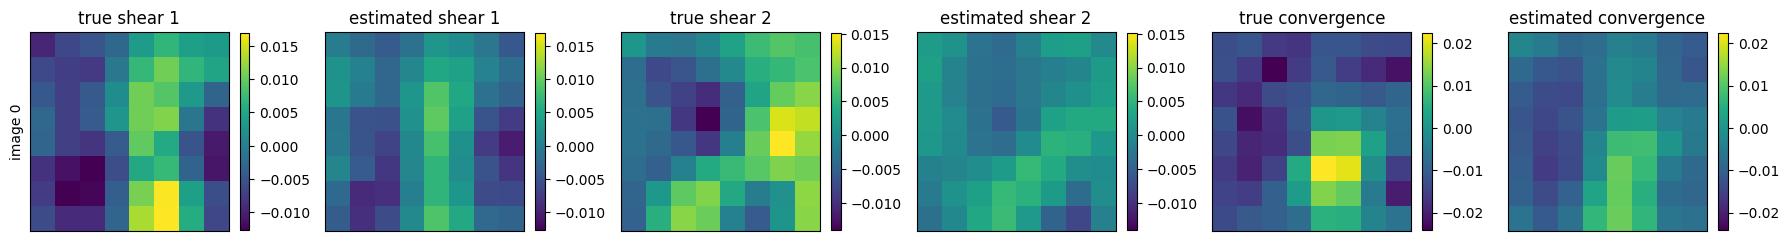

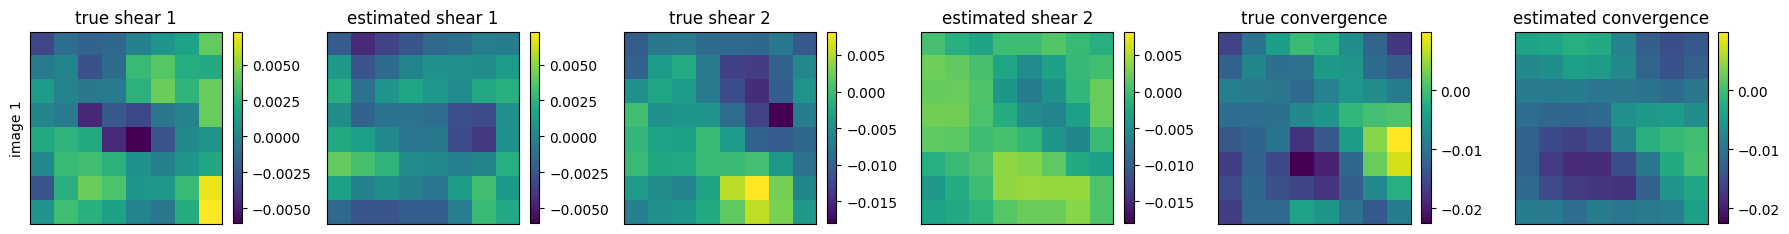

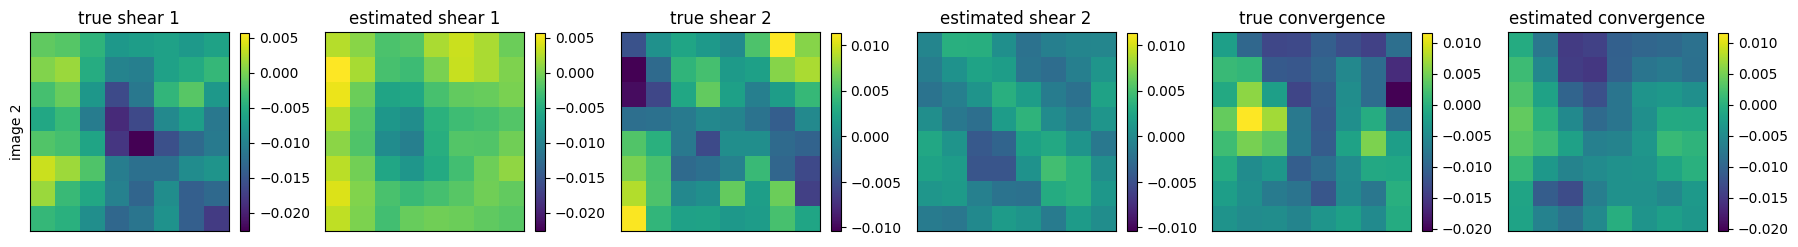

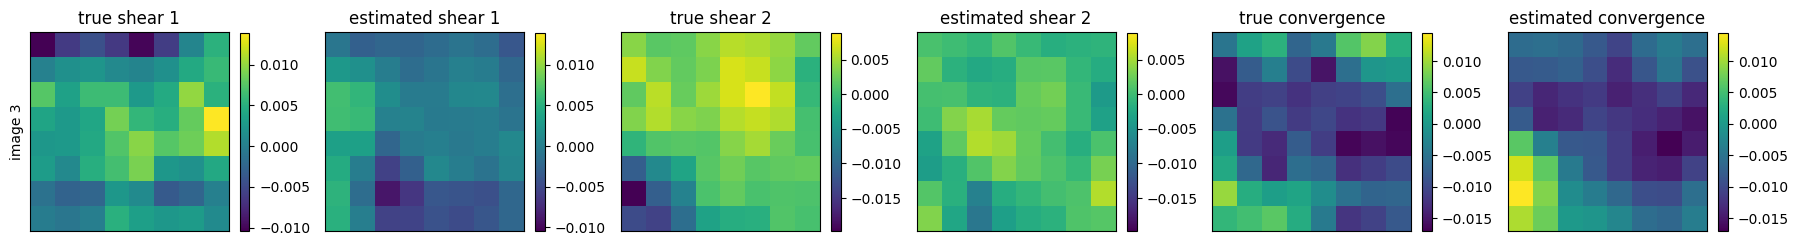

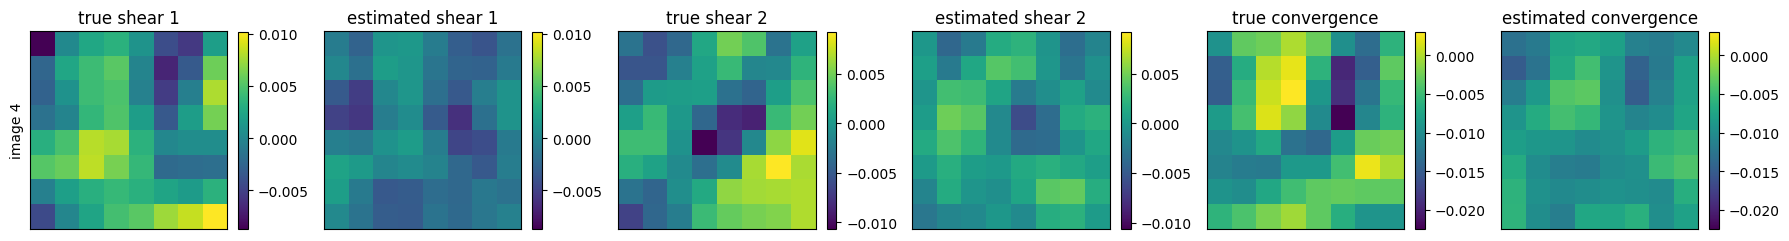

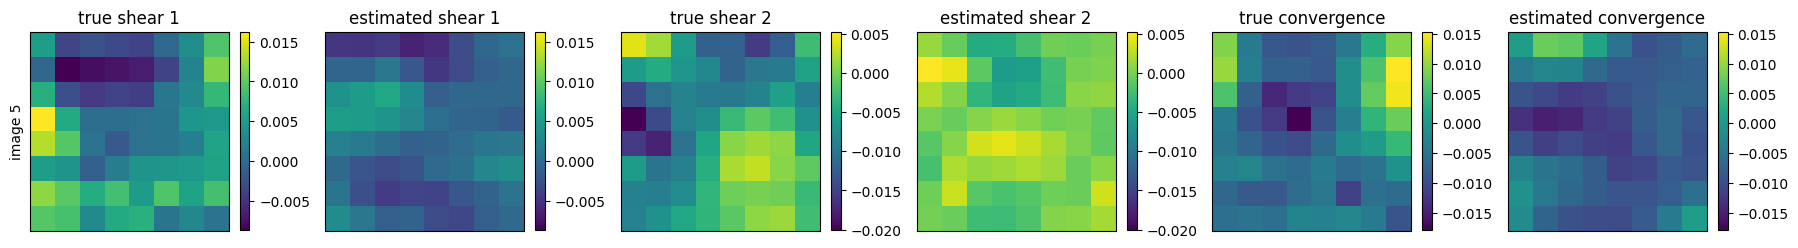

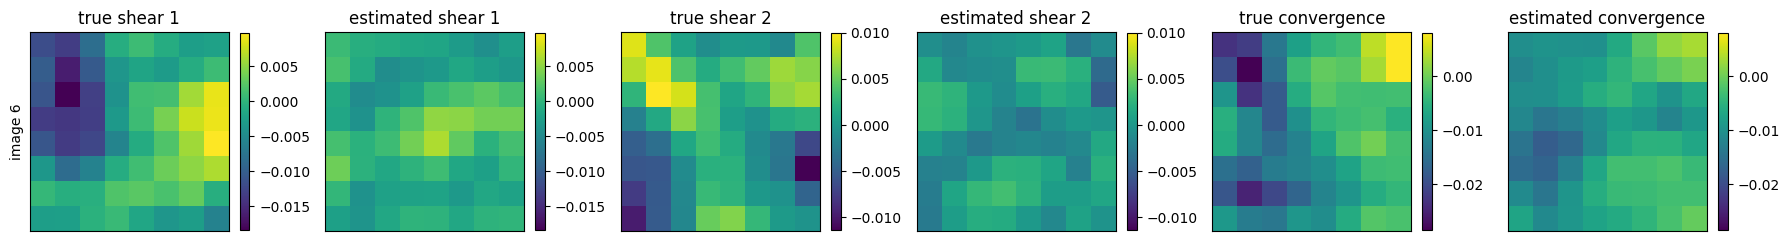

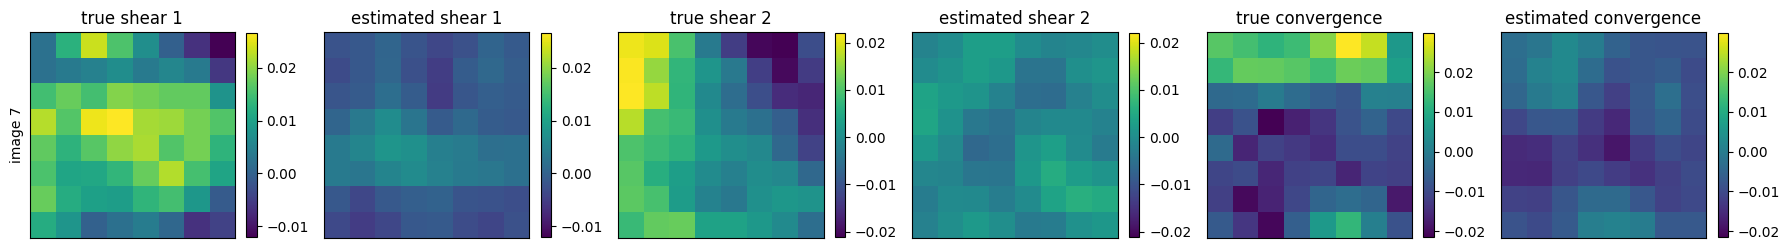

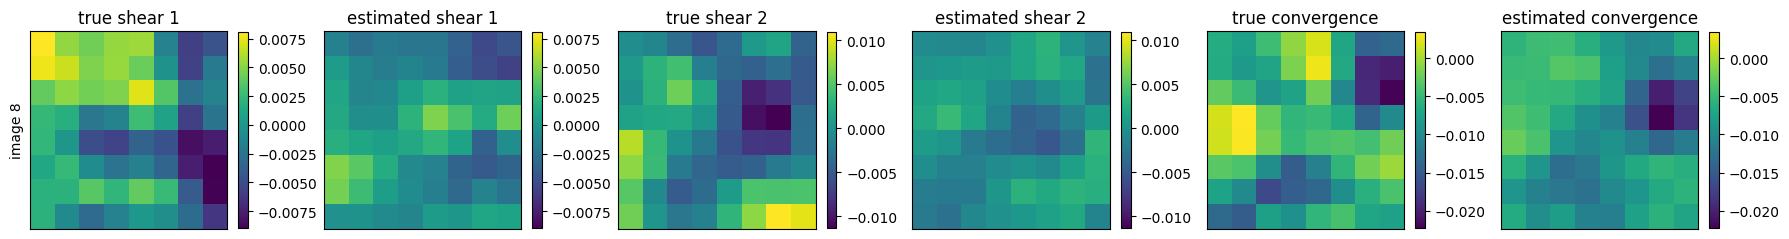

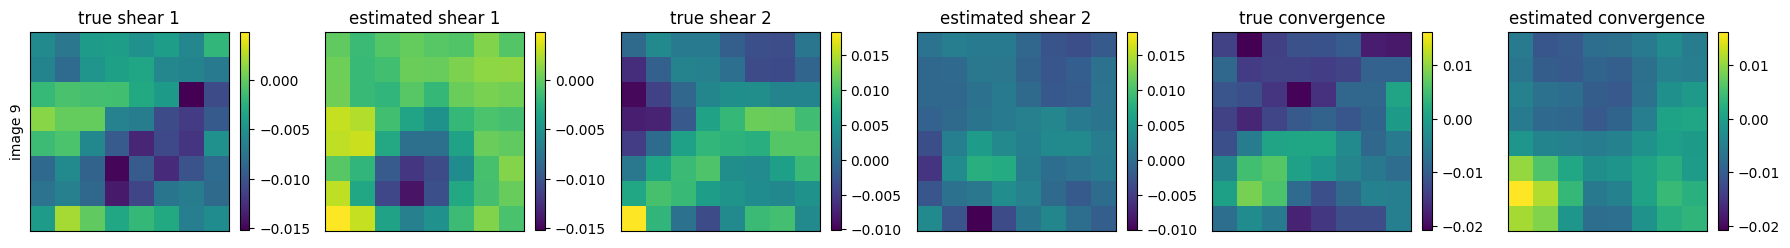

In [11]:
for img_index in range(10):

    fig, ax = plt.subplots(1,6,figsize=(18,3))
    
    vmin1 = min(shear1_true[img_index].min(), shear1_pred[img_index].min())
    vmax1 = max(shear1_true[img_index].max(), shear1_pred[img_index].max())
    vmin2 = min(shear2_true[img_index].min(), shear2_pred[img_index].min())
    vmax2 = max(shear2_true[img_index].max(), shear2_pred[img_index].max())
    vminc = min(convergence_true[img_index].min(), convergence_pred[img_index].min())
    vmaxc = max(convergence_true[img_index].max(), convergence_pred[img_index].max())
    
    true1 = ax[0].imshow(shear1_true[img_index].cpu(), vmin = vmin1, vmax = vmax1)
    plt.colorbar(true1, fraction = 0.045)
    ax[0].set_ylabel(f'image {img_index}')
    ax[0].set_title('true shear 1')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    pred1 = ax[1].imshow(shear1_pred[img_index].cpu(), vmin = vmin1, vmax = vmax1)
    plt.colorbar(pred1, fraction = 0.045)
    ax[1].set_title('estimated shear 1')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    true2 = ax[2].imshow(shear2_true[img_index].cpu(), vmin = vmin2, vmax = vmax2)
    plt.colorbar(true2, fraction = 0.045)
    ax[2].set_title('true shear 2')
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    
    pred2 = ax[3].imshow(shear2_pred[img_index].cpu(), vmin = vmin2, vmax = vmax2)
    plt.colorbar(pred2, fraction = 0.045)
    ax[3].set_title('estimated shear 2')
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    
    truec = ax[4].imshow(convergence_true[img_index].cpu(), vmin = vminc, vmax = vmaxc)
    plt.colorbar(truec, fraction = 0.045)
    ax[4].set_title('true convergence')
    ax[4].set_xticks([])
    ax[4].set_yticks([])
    
    predc = ax[5].imshow(convergence_pred[img_index].cpu(), vmin = vminc, vmax = vmaxc)
    plt.colorbar(predc, fraction = 0.045)
    ax[5].set_title('estimated convergence')
    ax[5].set_xticks([])
    ax[5].set_yticks([])
    
    fig.tight_layout()

Scatterplots of true vs. posterior mode shear and convergence:

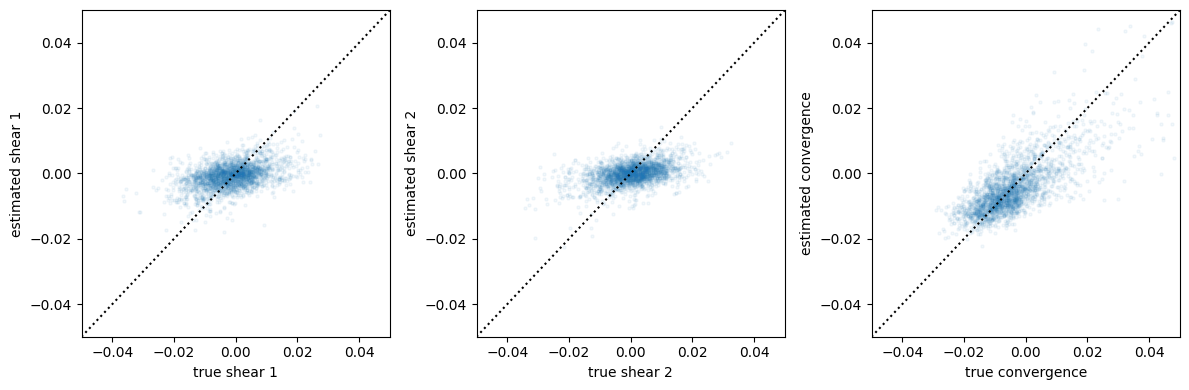

In [12]:
fig, ax = plt.subplots(1,3,figsize=(12,4))

_ = ax[0].scatter(shear1_true.flatten().cpu(), shear1_pred.flatten().cpu(), alpha = 0.05, s = 5)
_ = ax[0].set_xlabel('true shear 1')
_ = ax[0].set_ylabel('estimated shear 1')
_ = ax[0].set_xlim((-0.05, 0.05))
_ = ax[0].set_ylim((-0.05, 0.05))
_ = ax[0].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black')

_ = ax[1].scatter(shear2_true.flatten().cpu(), shear2_pred.flatten().cpu(), alpha = 0.05, s = 5)
_ = ax[1].set_xlabel('true shear 2')
_ = ax[1].set_ylabel('estimated shear 2')
_ = ax[1].set_xlim((-0.05, 0.05))
_ = ax[1].set_ylim((-0.05, 0.05))
_ = ax[1].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black')

_ = ax[2].scatter(convergence_true.flatten().cpu(), convergence_pred.flatten().cpu(), alpha = 0.05, s = 5)
_ = ax[2].set_xlabel('true convergence')
_ = ax[2].set_ylabel('estimated convergence')
_ = ax[2].set_xlim((-0.05, 0.05))
_ = ax[2].set_ylim((-0.05, 0.05))
_ = ax[2].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black')

fig.tight_layout()